# Clustering Patients by Lifestyle & Health Indicators to Assess Heart Disease Risk

This analysis clusters U.S. adults based on behavioral and lifestyle indicators to explore how different patterns relate to heart disease risk.

In [542]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Data Cleaning

In [543]:
# Load dataset 
df = pd.read_csv("heart_2022_no_nans.csv") 

# Select features for behavioral clustering 
features = ['Sex', 'AgeCategory', 'BMI', 'SleepHours', 'SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities'] 
df_subset = df[features].copy() 

# One-hot encode categorical variables 
df_encoded = pd.get_dummies(df_subset, drop_first=True) 

# Scale numeric variables 
scaler = StandardScaler() 
numeric_cols = ['BMI', 'SleepHours'] 
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols]) 
df_encoded.head() 

# Check for missing values 
print(df_encoded.isna().sum().sum(), "missing values found") 

# Check if all nows are numeric 
print("All numeric:", all(df_encoded.dtypes != 'object')) 

# Check scaling 
df_encoded.describe().T.head(10)

0 missing values found
All numeric: True


,count,mean,std,min,25%,50%,75%,max
BMI,246022.0,-1.386301e-17,1.000002,-2.555763,-0.675186,-0.185469,0.494609,10.589850
SleepHours,246022.0,2.546173e-16,1.000002,-4.179511,-0.708924,-0.014807,0.679311,11.785189


## Cluster Analysis

## Behavioral Clustering (K-Means)

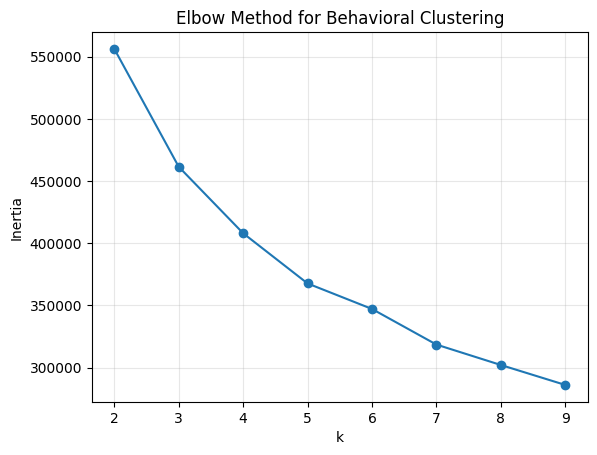

In [544]:
# Select behavioral features 
numeric_features = ['BMI', 'SleepHours'] 
categorical_features = ['PhysicalActivities', 'SmokerStatus', 'AlcoholDrinkers'] 

# One-hot encode categorical behavioral features 
df_behavioral_cat = pd.get_dummies(df[categorical_features], drop_first=True) 

# Concatenate numeric features 
df_behavioral_num = df[numeric_features].copy() 

# Scale numeric features 
scaler = StandardScaler() 
df_behavioral_num[numeric_features] = scaler.fit_transform(df_behavioral_num[numeric_features]) 

# Final dataset for clustering 
X_behavioral = pd.concat([df_behavioral_num, df_behavioral_cat], axis=1) 

# Find optimal k (elbow)
inertia = [] 
K_range = range(2, 10) 
for k in K_range: 
    km = KMeans(n_clusters=k, random_state=42) 
    km.fit(X_behavioral) 
    inertia.append(km.inertia_) 
    
plt.plot(K_range, inertia, marker='o') 
plt.xlabel('k') 
plt.ylabel('Inertia') 
plt.title('Elbow Method for Behavioral Clustering') 
plt.grid(True, alpha = 0.3) 
plt.show() 

# Fit final model 
kmeans = KMeans(n_clusters=4, random_state=42)
df['BehaviorCluster'] = kmeans.fit_predict(X_behavioral) + 1 

## Cluster Samples

In [552]:
# Show sample respondents from each cluster
rng = np.random.default_rng(42)

for cluster_id, subset in df.groupby("BehaviorCluster"):
    size = len(subset)
    print(f"\nCluster {cluster_id} - size: {size}")

    # Randomly select 2 sample individuals per cluster
    take = min(2, size)
    sampled_rows = rng.choice(subset.index.to_numpy(), size=take, replace=False)
    
    # Print a few relevant details
    for i in sampled_rows:
        row = df.loc[i, ['Sex', 'AgeCategory', 'BMI', 'SleepHours', 'SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities']]
        print(f"  ID {i} → Age: {row['AgeCategory']}, Sex: {row['Sex']}, BMI: {row['BMI']}, Sleep: {row['SleepHours']} hrs, Smoker: {row['SmokerStatus']}, Alcohol: {row['AlcoholDrinkers']}")


Cluster 1 - size: 40962
  ID 25166 → Age: Age 40 to 44, Sex: Male, BMI: 36.02, Sleep: 6.0 hrs, Smoker: Never smoked, Alcohol: Yes
  ID 190227 → Age: Age 35 to 39, Sex: Female, BMI: 33.28, Sleep: 7.0 hrs, Smoker: Never smoked, Alcohol: No

Cluster 2 - size: 57801
  ID 106342 → Age: Age 65 to 69, Sex: Female, BMI: 17.38, Sleep: 6.0 hrs, Smoker: Former smoker, Alcohol: Yes
  ID 105080 → Age: Age 30 to 34, Sex: Female, BMI: 29.29, Sleep: 6.0 hrs, Smoker: Former smoker, Alcohol: Yes

Cluster 3 - size: 53400
  ID 170568 → Age: Age 30 to 34, Sex: Male, BMI: 31.09, Sleep: 2.0 hrs, Smoker: Current smoker - now smokes every day, Alcohol: No
  ID 20493 → Age: Age 18 to 24, Sex: Female, BMI: 21.79, Sleep: 6.0 hrs, Smoker: Never smoked, Alcohol: No

Cluster 4 - size: 93859
  ID 22583 → Age: Age 30 to 34, Sex: Male, BMI: 27.41, Sleep: 7.0 hrs, Smoker: Never smoked, Alcohol: Yes
  ID 129838 → Age: Age 18 to 24, Sex: Male, BMI: 24.41, Sleep: 8.0 hrs, Smoker: Never smoked, Alcohol: No


## Demographic Distribution Across Clusters

Demographic Distribution Across Clusters


,Female,Male,18-34,35-54,55+
BehaviorCluster,,,,,
1,23488,17474,5665,14507,20790
2,26416,31385,4351,13711,39739
3,27455,25945,10287,17562,25551
4,50452,43407,17274,23473,53112


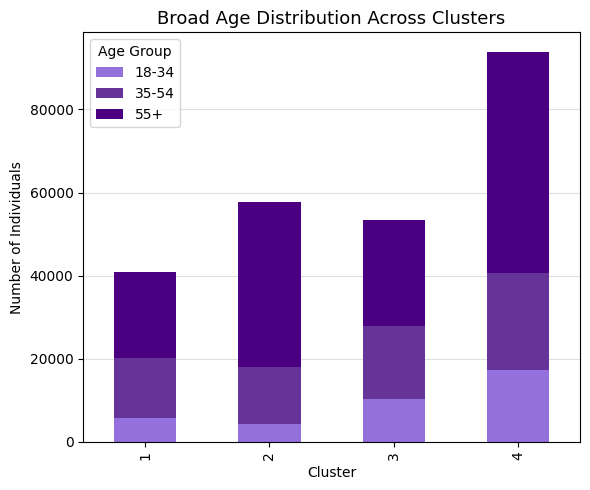

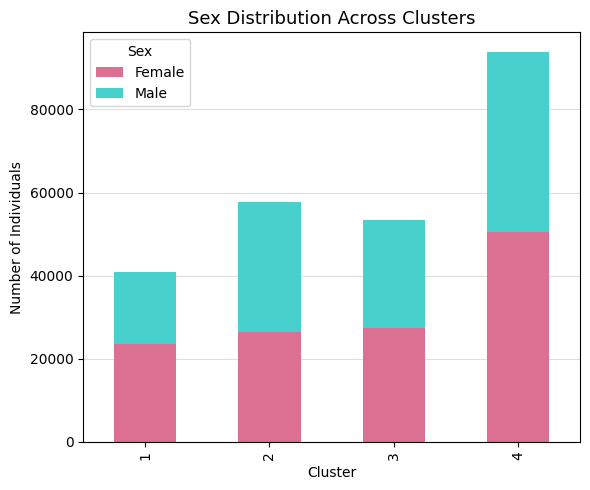

In [554]:
# Create broader age groups
age_map = {
    'Age 18 to 24':'18-34', 'Age 25 to 29':'18-34', 'Age 30 to 34':'18-34',
    'Age 35 to 39':'35-54', 'Age 40 to 44':'35-54', 'Age 45 to 49':'35-54',
    'Age 50 to 54':'35-54', 'Age 55 to 59':'55+', 'Age 60 to 64':'55+',
    'Age 65 to 69':'55+', 'Age 70 to 74':'55+', 'Age 75 to 79':'55+', 'Age 80 or older':'55+'
}
df['AgeGroupBroad'] = df['AgeCategory'].map(age_map)

# Create age and sex summary tables
age_table = df.groupby(['BehaviorCluster', 'AgeGroupBroad']).size().unstack(fill_value=0)
sex_table = df.groupby(['BehaviorCluster', 'Sex']).size().unstack(fill_value=0)

# 3. Combine both into one unified table
combined_table = pd.concat([sex_table, age_table], axis=1).fillna(0).astype(int)

# 4. Display the combined demographic table
print("Demographic Distribution Across Clusters")
display(combined_table)

# Plot age distribution
colors_age = ['mediumpurple', 'rebeccapurple', 'indigo']  
age_table.plot(kind='bar', stacked=True, figsize=(6,5), color=colors_age)
plt.title("Broad Age Distribution Across Clusters", fontsize=13)
plt.xlabel("Cluster")
plt.ylabel("Number of Individuals")
plt.legend(title="Age Group")
plt.grid(axis='y', alpha=0.4)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

# Plot sex distribution
colors_sex = ['palevioletred', 'mediumturquoise'] 
sex_table.plot(kind='bar', stacked=True, figsize=(6,5), color=colors_sex)
plt.title("Sex Distribution Across Clusters", fontsize=13)
plt.xlabel("Cluster")
plt.ylabel("Number of Individuals")
plt.legend(title="Sex")
plt.grid(axis='y', alpha=0.4)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()


## Health & Lifestyle Distribution Across Clusters

Health & Lifestyle Distribution Across Clusters


,BMI,SleepHours,SmokerRate,AlcoholRate,PhysicallyActiveRate
BehaviorCluster,,,,,
1,39.5,6.9,0.4,0.5,0.6
2,27.0,7.3,1.0,0.6,0.8
3,27.0,5.3,0.3,0.5,0.8
4,25.9,7.8,0.1,0.6,0.8


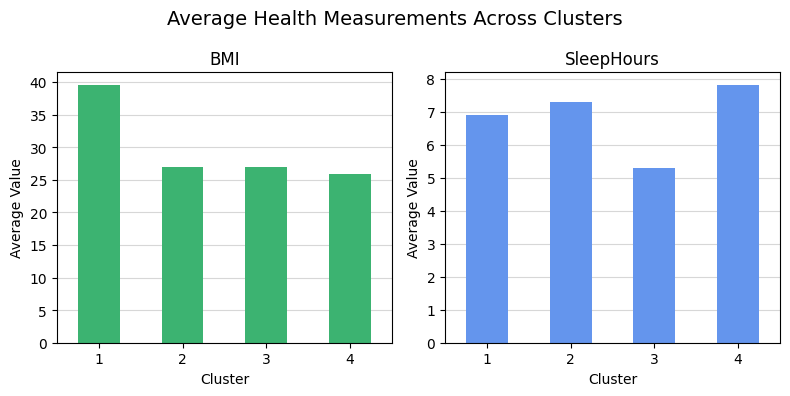

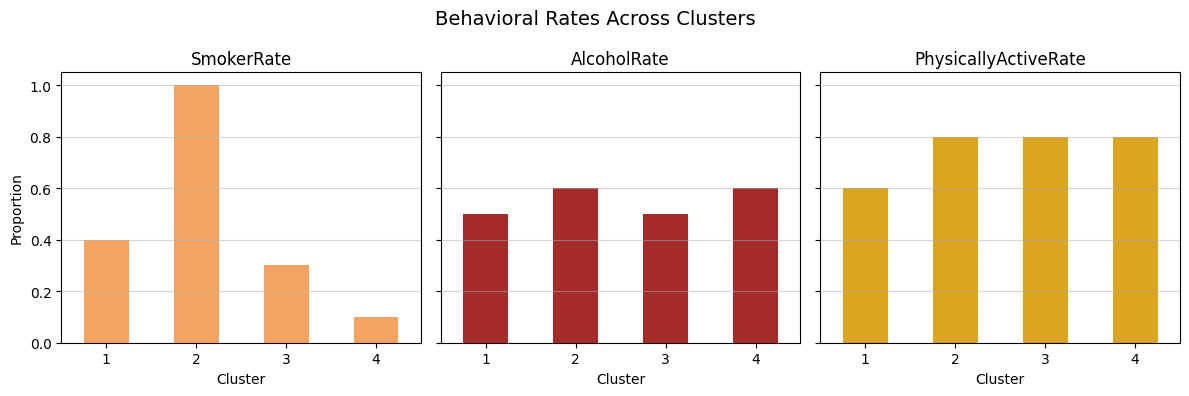

In [547]:
# Shift clusters to start from 1 instead of 0
df['BehaviorCluster'] = df['BehaviorCluster']

# Summary table for behavioral characteristics per cluster
cluster_summary = df.groupby('BehaviorCluster')[['BMI', 'SleepHours']].mean()

# Add proportions for categorical behaviors
cluster_summary['SmokerRate'] = df.groupby('BehaviorCluster')['SmokerStatus'].apply(
    lambda x: x.isin([
        'Former smoker',
        'Current smoker - now smokes some days',
        'Current smoker - now smokes every day'
    ]).mean()
)
cluster_summary['AlcoholRate'] = df.groupby('BehaviorCluster')['AlcoholDrinkers'].apply(
    lambda x: (x == 'Yes').mean()
)
cluster_summary['PhysicallyActiveRate'] = df.groupby('BehaviorCluster')['PhysicalActivities'].apply(
    lambda x: (x == 'Yes').mean()
)

# Round for readability
cluster_summary = cluster_summary.round(1)
print("Health & Lifestyle Distribution Across Clusters")
display(cluster_summary)

# Plot average BMI and SleepHours
variables = ['BMI', 'SleepHours']
colors = ['mediumseagreen', 'cornflowerblue']

fig, axes = plt.subplots(1, 2, figsize=(8,4), sharey=False)

for ax, var, color in zip(axes, variables, colors):
    cluster_summary[var].plot(kind='bar', color=color, ax=ax)
    ax.set_title(var)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Value')
    ax.grid(axis='y', alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_xticklabels(cluster_summary.index, rotation=0)

plt.suptitle('Average Health Metrics Across Clusters', fontsize=14)
plt.tight_layout()
plt.show()

# Plot SmokerRate, AlcoholRate, and PhysicallyActiveRate
variables = ['SmokerRate', 'AlcoholRate', 'PhysicallyActiveRate']
colors = ['sandybrown', 'brown', 'goldenrod']

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for ax, var, color in zip(axes, variables, colors):
    cluster_summary[var].plot(kind='bar', color=color, ax=ax)
    ax.set_title(var)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Proportion')
    ax.grid(axis='y', alpha=0.5)
    ax.set_xticklabels(cluster_summary.index, rotation=0)

plt.suptitle('Lifestyle Behavior Rates Across Clusters', fontsize=14)
plt.tight_layout()
plt.show()



## Cluster Distribution (PCA)

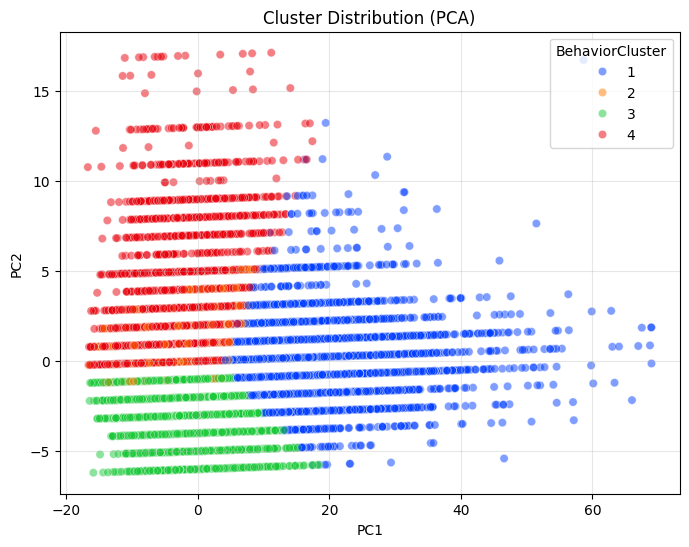

In [548]:
# Create binary columns
df['SmokerFlag'] = df['SmokerStatus'].apply(lambda x: 1 if x != 'Never smoked' else 0)
df['AlcoholFlag'] = df['AlcoholDrinkers'].apply(lambda x: 1 if x == 'Yes' else 0)
df['ActiveFlag'] = df['PhysicalActivities'].apply(lambda x: 1 if x == 'Yes' else 0)

# Features for PCA
features = ['BMI', 'SleepHours', 'SmokerFlag', 'AlcoholFlag', 'ActiveFlag']
X = df[features]

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
df['PCA1'] = pca_result[:,0]
df['PCA2'] = pca_result[:,1]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='BehaviorCluster', palette='bright', alpha=0.5)
plt.title("Cluster Distribution (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()


## Heart Disease Risk Across Clusters

Heart Disease Risk Across Clusters


,HeartDiseaseRiskProportion
BehaviorCluster,
1,12.8%
2,14.9%
3,11.7%
4,8.7%


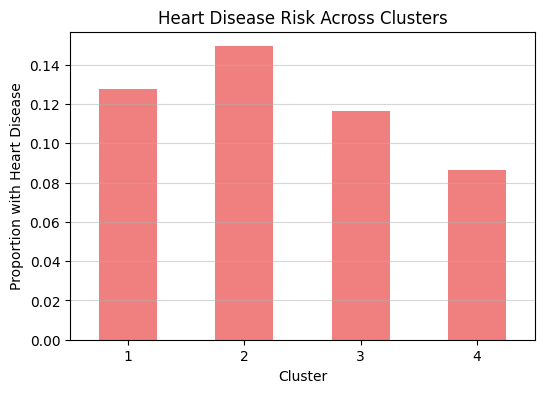

In [549]:
# Convert heart disease indicators to 0/1
for col in ['HadHeartAttack','HadAngina','HadStroke']:
    df[col] = df[col].map({'Yes':1, 'No':0})

# Create a single "HeartDiseaseRisk" flag if any condition is present
df['HeartDiseaseRisk'] = df[['HadHeartAttack','HadAngina','HadStroke']].any(axis=1).astype(int)

# Compute proportion of heart disease risk by cluster
heart_disease_by_cluster = df.groupby('BehaviorCluster')['HeartDiseaseRisk'].mean()

# Convert Series to DataFrame
heart_disease_table = heart_disease_by_cluster.reset_index()
heart_disease_table.columns = ['BehaviorCluster', 'HeartDiseaseRiskProportion']
heart_disease_table.set_index('BehaviorCluster', inplace=True)

# Format the proportion as percentage for readability
heart_disease_table['HeartDiseaseRiskProportion'] = heart_disease_table['HeartDiseaseRiskProportion'].apply(lambda x: f"{x:.1%}")

# Display the table
print("Heart Disease Risk Across Clusters")
display(heart_disease_table)

# Plot
heart_disease_by_cluster.plot(kind='bar', color='lightcoral', figsize=(6,4))
plt.title("Heart Disease Risk Across Clusters")
plt.ylabel("Proportion with Heart Disease")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

## Cluster Profiles

In [556]:
# Behavioral, demographic, and interpretation summaries
cluster_data = [
    {
        "Cluster": 1,
        "DemographicTrends": "Mostly ages 55+ - more female than male",
        "BehavioralTraits": "BMI: 39.5 - Sleep: 6.9 hrs - Smoker: 0.4 - Alcohol: 0.5 - Physically active: 0.6",
        "HeartDiseaseRisk": "12.8%",
        "Profile": "Older, predominantly female adults with obesity"
    },
    {
        "Cluster": 2,
        "DemographicTrends": "Mostly ages 55+ - fairly balanced male-female ratio",
        "BehavioralTraits": "BMI: 27 - Sleep: 7.3 hrs - Smoker: 1 - Alcohol: 0.6 - Physically active: 0.8",
        "HeartDiseaseRisk": "14.9%",
        "Profile": "Older adults with high smoking prevalence"
    },
    {
        "Cluster": 3,
        "DemographicTrends": "Spread across all age groups - slightly more female",
        "BehavioralTraits": "BMI: 27 - Sleep: 5.3 hrs - Smoker: 0.3 - Alcohol: 0.5 - Physically active: 0.8",
        "HeartDiseaseRisk": "11.7%",
        "Profile": "Mixed-age group with short sleep duration"
    },
    {
        "Cluster": 4,
        "DemographicTrends": "High representation of 18–34 and 55+ - more female",
        "BehavioralTraits": "BMI: 26 - Sleep: 7.8 hrs - Smoker: 0.1 - Alcohol: 0.6 - Physically active: 0.8",
        "HeartDiseaseRisk": "8.7%",
        "Profile": "Health-conscious, active individuals"
    }
]

# Create dataframe for table
cluster_table = pd.DataFrame(cluster_data)

# Edit table details
cluster_table.set_index("Cluster", inplace=True)
pd.set_option('display.max_colwidth', None)

# Display updated table
print("Cluster Profiles with Demographic Trends, Behavioral Traits, and Heart Disease Risk")
display(cluster_table)


Cluster Profiles with Demographic Trends, Behavioral Traits, and Heart Disease Risk


,DemographicTrends,BehavioralTraits,HeartDiseaseRisk,Profile
Cluster,,,,
1,Mostly ages 55+ - more female than male,BMI: 39.5 - Sleep: 6.9 hrs - Smoker: 0.4 - Alcohol: 0.5 - Physically active: 0.6,12.8%,"Older, predominantly female adults with obesity"
2,Mostly ages 55+ - fairly balanced male-female ratio,BMI: 27 - Sleep: 7.3 hrs - Smoker: 1 - Alcohol: 0.6 - Physically active: 0.8,14.9%,Older adults with high smoking prevalence
3,Spread across all age groups - slightly more female,BMI: 27 - Sleep: 5.3 hrs - Smoker: 0.3 - Alcohol: 0.5 - Physically active: 0.8,11.7%,Mixed-age group with short sleep duration
4,High representation of 18–34 and 55+ - more female,BMI: 26 - Sleep: 7.8 hrs - Smoker: 0.1 - Alcohol: 0.6 - Physically active: 0.8,8.7%,"Health-conscious, active individuals"
